# Ranking

Second Assignement of Learning with Massive Data. 


Pah of documents and queries

In [1]:
path_name_documents = './Databases/prova/gigi.jsonl'
path_name_query = './Databases/prova/queries.jsonl'

#path_name_documents = './Databases/trec-covid/corpus.jsonl'
#path_name_query = './Databases/trec-covid/queries.jsonl'

# Usefull Functions

In [2]:
import pandas as pd

def score_table(score):
    df = pd.DataFrame(score)

    df.index = ["Query " + str(i+1) for i in range(len(df.index))]    #i+1
    df.columns = ["Document " + str(i+1) for i in range(len(df.columns))]

    return df


def printDocsQuery(documents,queries,results_k,list_top_k):  
    for query in queries:   
        print("QUERY: "+ query[1])
        print()
        elem = int(query[0])-1
        doc = [a for a, b in list_top_k[elem]]
        for position in doc:
            #print(documents[position][0])
            print(position)
            print()
    



# Read Files

In [3]:
import json
import numpy as np
import string

def readFile(path_name):
    # Load the JSONL file into a list
    with open(path_name, 'r') as f:
        lines = f.readlines()

    # Convert each JSON object into a dictionary
    dicts = [json.loads(line) for line in lines]

    # Convert the dictionaries into arrays and stack them vertically
    arrays = np.vstack([np.array(list(d.values())) for d in dicts])

    # Convert the arrays into a list of lists
    text = arrays.tolist()
    
    return text

documents = readFile(path_name_documents)
queries = readFile(path_name_query)


# Tokenize, Stemming and Lemming

In [4]:
import json
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


stop_words = set(stopwords.words('english'))

def stemmingLemming(filtered_tokens):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Perform stemming or lemmatization on filtered tokens
    
    filtered_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return filtered_tokens
    
 
    

def tokenize(path_name):
    
    with open(path_name, "r") as f:
        data = f.readlines()

        # Create an empty list to store the tokenized documents
        tokenized_docs = []

        # Loop through each line in the JSONL file
        for line in data:
            # Parse the JSON string into a Python dictionary
            doc = json.loads(line)

            # Extract the text from the dictionary
            text = doc['text']
            text = text.lower()  # Convert to lowercase
            #text = re.sub(r'\d+', '', text)  # Remove all numbers
            text = text.translate(str.maketrans('', '', string.punctuation))  # Remove all punctuation

            # Tokenize the text using NLTK
            tokens = word_tokenize(text)
            tokensStemLem = stemmingLemming(tokens)

            # Add the tokenized document to the list
            tokenized_docs.append(tokensStemLem)

        # Print the tokenized documents
    return tokenized_docs


tokenized_docs = tokenize(path_name_documents)
tokenized_query = tokenize(path_name_query)




# Sparse Vectors



### TF-IDF 

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

def calculateTFIDF(tokenized_docs):
    # Initialize the TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the tokenized documents into a TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform([' '.join(doc) for doc in tokenized_docs])

    # Get the feature names (tokens)
    feature_names = vectorizer.get_feature_names()

    # Return the TF-IDF matrix and the feature names
    return tfidf_matrix, feature_names,vectorizer
 
    
    
def calculateTFIDFQuery(tokenized_query,vectorizer):
    
    # Fit and transform the tokenized documents into a TF-IDF matrix
    tfidf_matrix = vectorizer.transform([' '.join(doc) for doc in tokenized_query])

    # Get the feature names (tokens)
    feature_names = vectorizer.get_feature_names()

    # Return the TF-IDF matrix and the feature names
    return tfidf_matrix, feature_names

    

tfidf_matrix_docs, feature_names_docs,vectorizer  = calculateTFIDF(tokenized_docs)
tfidf_matrix_query, feature_names_query  = calculateTFIDFQuery( tokenized_query,vectorizer)



C:\Users\lita4\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Dot Product for Sparse Vectors

In [6]:
import numpy as np

def dot_prod(tfidf_matrix_docs, tfidf_matrix_query):
    matrix_docs = tfidf_matrix_docs.toarray()
    matrix_query = tfidf_matrix_query.toarray()
    dot_result = tfidf_matrix_docs.dot(tfidf_matrix_query)
    return dot_result
    
    


def calculate_Dot_Product_Sparse(tfidf_matrix_docs, tfidf_matrix_query):
    matrix_docs = tfidf_matrix_docs.toarray()
    matrix_query = tfidf_matrix_query.toarray()
    num_queries = matrix_query.shape[0]
    num_docs = matrix_docs.shape[0]
    sparse_score_results = []
    
    for query in range(num_queries):
        sparse_score_docs = []
        for doc in range(num_docs):
            dot_result = matrix_query[query].dot(matrix_docs[doc]) #np.dot(matrix_query[query], matrix_docs[doc])
            sparse_score_docs.append(dot_result)
        sparse_score_results.append(sparse_score_docs)
        
    return sparse_score_results


sparse_score_results = calculate_Dot_Product_Sparse(tfidf_matrix_docs,tfidf_matrix_query)
sparse_score_table = score_table(sparse_score_results)
sparse_score_table
 #dot_prod = dot_prod(tfidf_matrix_docs,tfidf_matrix_query)
#dot_prod




,Document 1,Document 2,Document 3,Document 4,Document 5,Document 6,Document 7,Document 8,Document 9,Document 10,...,Document 3990,Document 3991,Document 3992,Document 3993,Document 3994,Document 3995,Document 3996,Document 3997,Document 3998,Document 3999
Query 1,0.029370,0.077534,0.067317,0.033213,0.036547,0.035836,0.018249,0.055079,0.024687,0.036765,...,0.048974,0.039934,0.023264,0.032351,0.018753,0.032246,0.072539,0.027884,0.036104,0.037660
Query 2,0.021919,0.041142,0.054071,0.014042,0.066981,0.023871,0.077872,0.027938,0.040470,0.032439,...,0.036471,0.032148,0.016102,0.030656,0.017601,0.025349,0.030003,0.018524,0.026930,0.053409
Query 3,0.021584,0.006323,0.026454,0.037933,0.047134,0.001841,0.026966,0.004492,0.022789,0.000000,...,0.030639,0.002382,0.011902,0.010098,0.012483,0.009361,0.017431,0.004917,0.004423,0.026542
Query 4,0.008322,0.000000,0.004673,0.000000,0.023672,0.012677,0.000000,0.000000,0.004198,0.010414,...,0.017475,0.017964,0.000000,0.003883,0.004668,0.012326,0.000000,0.000000,0.010231,0.015009
Query 5,0.005123,0.024111,0.019571,0.040776,0.009565,0.008902,0.025560,0.006348,0.021141,0.016858,...,0.025661,0.024839,0.004215,0.029594,0.021596,0.048231,0.048591,0.011223,0.012597,0.049486
Query 6,0.012182,0.037043,0.026902,0.024325,0.015992,0.012372,0.016690,0.019104,0.014209,0.024298,...,0.025861,0.024696,0.011953,0.012568,0.012986,0.032218,0.035861,0.025093,0.028603,0.034338
Query 7,0.006098,0.020019,0.022697,0.007434,0.030940,0.013669,0.024026,0.003731,0.007267,0.024465,...,0.016007,0.020323,0.003387,0.020928,0.013522,0.005795,0.012878,0.008398,0.012102,0.027586
Query 8,0.021640,0.061524,0.046124,0.025916,0.036058,0.022845,0.022729,0.035459,0.025275,0.028412,...,0.028885,0.039906,0.021122,0.025608,0.014532,0.030753,0.044465,0.027442,0.034891,0.049287
Query 9,0.014795,0.000000,0.000000,0.014451,0.000000,0.000000,0.000000,0.000000,0.000000,0.014651,...,0.000000,0.007692,0.000000,0.000000,0.000000,0.045940,0.004691,0.005558,0.000000,0.000000
Query 10,0.057452,0.053740,0.032272,0.028235,0.021772,0.024814,0.007732,0.035084,0.022347,0.035244,...,0.035008,0.030418,0.016596,0.021025,0.007631,0.020412,0.031311,0.022900,0.036598,0.069343


# Dense Vector

In [7]:
from sentence_transformers import SentenceTransformer

def create_dense_vector(document):
    # Load the all-MiniLM-L6-v2 model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Create a dense vector representation of the document
    dense_vector = model.encode(document, convert_to_tensor=True)
    
    
    return dense_vector


dense_vector_document = create_dense_vector(documents)
dense_vector_query = create_dense_vector(queries)




### Dot Product for Dense Vector

In [8]:
def calculate_Dot_Product_Dense(dense_vector_document, dense_vector_query):
    num_queries = dense_vector_query.shape[0]
    num_docs = dense_vector_document.shape[0]
    dense_score_results = []
    
    for query in range(num_queries):
        dense_score_docs = []
        for doc in range(num_docs):
            dot_result = np.dot(dense_vector_query[query], dense_vector_document[doc]) #dense_vector_query[query].dot(dense_vector_document[doc])
            dense_score_docs.append(dot_result)
        dense_score_results.append(dense_score_docs)
        
    return dense_score_results


dense_score_results = calculate_Dot_Product_Dense(dense_vector_document, dense_vector_query)
dense_score_table = score_table(dense_score_results)
dense_score_table
    

,Document 1,Document 2,Document 3,Document 4,Document 5,Document 6,Document 7,Document 8,Document 9,Document 10,...,Document 3990,Document 3991,Document 3992,Document 3993,Document 3994,Document 3995,Document 3996,Document 3997,Document 3998,Document 3999
Query 1,0.133962,0.106983,0.226969,0.126819,0.324864,0.217792,0.038656,0.038245,0.077958,0.173893,...,0.107710,0.110529,0.037086,0.252619,0.144514,0.062983,0.002433,0.140019,0.158613,0.143412
Query 2,0.066888,0.096966,0.279706,0.121130,0.310443,0.200889,0.052011,0.070468,0.099590,0.161712,...,0.114768,-0.059720,-0.058169,0.142583,0.004494,0.062359,-0.032569,0.044852,0.248242,0.173814
Query 3,0.194564,0.120762,0.322730,0.129222,0.261768,0.200194,0.167548,0.103854,0.115690,0.136201,...,0.209211,0.078913,0.006605,0.252819,0.086904,0.109192,0.005952,-0.014556,0.194796,0.239386
Query 4,0.131543,0.226517,0.249557,0.214995,0.339539,0.206882,0.168591,0.175452,0.144724,0.111294,...,0.208750,0.119516,-0.041545,0.277264,0.190965,0.153521,0.074839,0.049263,0.141285,0.290199
Query 5,0.095667,0.222562,0.330017,0.203857,0.242839,0.142185,0.110872,0.190014,0.229337,0.148948,...,0.165211,0.196564,0.087642,0.281969,0.063326,0.161981,0.192557,0.106632,0.104079,0.168073
Query 6,0.173545,0.096595,0.171428,0.057788,0.219801,0.182564,0.211420,0.147272,0.092435,0.271069,...,0.101990,0.175637,0.036463,0.269230,0.234571,0.055306,0.006769,0.112853,0.124259,0.153882
Query 7,0.213392,0.104680,0.231447,0.153244,0.285167,0.150482,0.233630,0.177980,0.174007,0.183099,...,0.214363,0.161521,-0.008314,0.346103,0.132104,0.146105,0.003593,0.199095,0.158166,0.189181
Query 8,0.152630,0.118768,0.170204,0.102133,0.181831,0.162573,0.278159,0.135007,0.129492,0.202244,...,0.085802,0.101139,-0.011850,0.312797,0.220416,0.088656,0.008311,0.116053,0.141496,0.214448
Query 9,0.066558,0.064783,0.082429,0.083235,0.219832,0.130397,0.147970,0.148426,0.025930,0.148640,...,0.064402,0.070608,0.044075,0.149553,0.194655,-0.008127,0.044905,0.052529,0.131430,0.198693
Query 10,0.082550,0.118295,0.100848,0.094167,0.132487,0.084940,0.176099,0.119457,0.024127,0.221782,...,0.148982,0.028777,-0.017483,0.200622,0.105480,-0.005434,0.029036,0.030615,0.155371,0.213219


# Calculate the final score for each query

In [10]:
import numpy as np


def calculate_full_score(sparse_score_results,dense_score_results):
    sparse_vector = np.stack(sparse_score_results)
    dense_vector = np.stack(dense_score_results)
    full_vector = sparse_vector + dense_vector
    
    return full_vector, dense_vector,sparse_vector
    
full_vector, dense_vector,sparse_vector = calculate_full_score(sparse_score_results,dense_score_results)

df = score_table(full_vector)
df

,Document 1,Document 2,Document 3,Document 4,Document 5,Document 6,Document 7,Document 8,Document 9,Document 10,...,Document 3990,Document 3991,Document 3992,Document 3993,Document 3994,Document 3995,Document 3996,Document 3997,Document 3998,Document 3999
Query 1,0.163333,0.184517,0.294286,0.160032,0.361411,0.253628,0.056905,0.093324,0.102645,0.210658,...,0.156684,0.150463,0.060351,0.284970,0.163267,0.095230,0.074971,0.167902,0.194717,0.181071
Query 2,0.088807,0.138107,0.333777,0.135172,0.377424,0.224759,0.129883,0.098406,0.140060,0.194152,...,0.151238,-0.027573,-0.042068,0.173238,0.022095,0.087708,-0.002567,0.063376,0.275172,0.227224
Query 3,0.216148,0.127085,0.349184,0.167155,0.308901,0.202034,0.194514,0.108346,0.138479,0.136201,...,0.239850,0.081295,0.018506,0.262917,0.099386,0.118553,0.023383,-0.009638,0.199218,0.265928
Query 4,0.139864,0.226517,0.254230,0.214995,0.363211,0.219559,0.168591,0.175452,0.148921,0.121708,...,0.226226,0.137480,-0.041545,0.281147,0.195632,0.165846,0.074839,0.049263,0.151515,0.305208
Query 5,0.100790,0.246673,0.349588,0.244633,0.252404,0.151086,0.136433,0.196362,0.250478,0.165806,...,0.190872,0.221404,0.091857,0.311563,0.084921,0.210212,0.241148,0.117855,0.116677,0.217558
Query 6,0.185727,0.133639,0.198330,0.082113,0.235793,0.194936,0.228110,0.166376,0.106644,0.295368,...,0.127851,0.200333,0.048416,0.281798,0.247557,0.087524,0.042630,0.137946,0.152862,0.188220
Query 7,0.219491,0.124699,0.254144,0.160678,0.316107,0.164151,0.257656,0.181711,0.181275,0.207563,...,0.230370,0.181844,-0.004927,0.367031,0.145627,0.151900,0.016471,0.207493,0.170268,0.216767
Query 8,0.174270,0.180292,0.216329,0.128049,0.217889,0.185417,0.300887,0.170466,0.154767,0.230657,...,0.114687,0.141045,0.009272,0.338405,0.234949,0.119408,0.052776,0.143495,0.176387,0.263735
Query 9,0.081353,0.064783,0.082429,0.097686,0.219832,0.130397,0.147970,0.148426,0.025930,0.163291,...,0.064402,0.078300,0.044075,0.149553,0.194655,0.037813,0.049596,0.058087,0.131430,0.198693
Query 10,0.140002,0.172035,0.133120,0.122401,0.154259,0.109754,0.183831,0.154542,0.046474,0.257026,...,0.183989,0.059195,-0.000887,0.221647,0.113111,0.014977,0.060347,0.053515,0.191969,0.282561


# Choose parameters

## Select query

Initialize the vector for the specific query choosen

In [50]:
def initialize_vectors(n_query):
    score_sparse = sparse_vector [n_query]
    score_dense = dense_vector [n_query]
    score_full = full_vector [n_query]
    
    return score_sparse, score_dense, score_full

#score_sparse, score_dense,score_full = initialize_vectors(1)    

In [51]:
#score_dense[::-1][250]

In [52]:
#score_sparse[::-1][250]

In [53]:
#score_full

In [54]:
#take the position of top k score
def ground_truth_tok_k(K,score_full):
    ground_truth = np.argsort(score_full)[::-1][:K]
    
    return ground_truth 

#ground_truth = ground_truth_tok_k(K,score_full)
#ground_truth



### For sparse and dense vector we take the best k_p elements

In [55]:
def best_top_k_first(K_p,score_dense,score_sparse):
    best_dense = np.argsort(score_dense)[::-1][:K_p]
    best_sparse = np.argsort(score_sparse)[::-1][:K_p]
    
    return best_sparse, best_dense


best_sparse, best_dense = best_top_k_first(250,score_dense,score_sparse)   



In [56]:
#best_sparse

In [57]:
#best_dense

### Union, without duplicate, of best sparse and best dense elements of vectors

In [58]:
def union_best_vectors(best_sparse, best_dense):
    best_index_score = list(set(list(best_sparse) + list(best_dense))) #union
    return best_index_score

best_index_score = union_best_vectors(best_sparse, best_dense)

### Take the best score from the final score list using the indexes of sparse and dense union list and also return the best indexes sorted

In [59]:
def ordina_lista(listaA, listaB):
    # Creiamo una lista vuota C della stessa lunghezza di listaA
    listaC = [0] * len(listaA)
    # Iteriamo su tutti gli elementi di listaB
    for i in range(len(listaB)):
        # L'elemento di listaC corrispondente alla posizione i di listaB diventa l'elemento di listaA corrispondente alla posizione listaB[i]
        listaC[i] = listaA[listaB[i]]
    # Restituiamo la lista ordinata listaC
    return listaC


In [60]:
def best_full_score_function(best_index_score,score_full):

    best_full_score = score_full[best_index_score]
    order_best_full_score = np.argsort(best_full_score)[::-1]  #questo lo ordino per ordinare i miei 
    order_best_full_score = ordina_lista(best_index_score,order_best_full_score)
    return best_full_score, order_best_full_score



#best_full_score, order_best_full_score = best_full_score_function(best_index_score,score_full)



In [61]:
#best_full_score

In [62]:
#order_best_full_score

## Create a list with the indexes of best score ordered and take the first K.

In [63]:

def retrieved_K_indexes(order_best_full_score,K):
    actual_order = list(order_best_full_score)
    k_indexes_ordered = actual_order[:K]
    
    return k_indexes_ordered

#k_indexes_ordered = retrieved_K_indexes(order_best_full_score,K)
#k_indexes_ordered

 

In [64]:
def calculate_relevant_docs(k_indexes_ordered,ground_truth):
    relevant = set(k_indexes_ordered).intersection(ground_truth)
    real_relevant_docs =len(relevant)/len(ground_truth)
    return real_relevant_docs

#real_relevant_docs = calculate_relevant_docs(k_indexes_ordered,ground_truth)
#print("PERCENTAGE REAL RELEVANT DOCUMENTS - RACALL:")
#real_relevant_docs
    

In [69]:
def execution(K, full_vector, dense_vector,sparse_vector):
    number_query = full_vector.shape[0]
    number_documents = full_vector.shape[1]
    
    results = []

  
    for query in range(0, number_query):
    
        #print("QUERY:" + str(query))
        #print()
              
        for k_first in range(K, number_documents):
            
            

            score_sparse, score_dense,score_full = initialize_vectors(query)

            ground_truth = ground_truth_tok_k(K,score_full)

            best_sparse, best_dense = best_top_k_first(k_first,score_dense,score_sparse)  

            best_index_score = union_best_vectors(best_sparse, best_dense)

            best_full_score, order_best_full_score = best_full_score_function(best_index_score,score_full)

            k_indexes_ordered = retrieved_K_indexes(order_best_full_score, K)

            real_relevant_docs = calculate_relevant_docs(k_indexes_ordered,ground_truth)
            #print("K-FIRST:" + str(k_first))
            #print("PERCENTAGE REAL RELEVANT - RACALL:")
            #print(real_relevant_docs)
            
            results.append((k_first, real_relevant_docs))
            


    return results
       
results = execution(15, full_vector, dense_vector,sparse_vector)
results
        


[(15, 0.4666666666666667),
 (16, 0.4666666666666667),
 (17, 0.4666666666666667),
 (18, 0.6),
 (19, 0.6),
 (20, 0.6),
 (21, 0.6666666666666666),
 (22, 0.7333333333333333),
 (23, 0.7333333333333333),
 (24, 0.7333333333333333),
 (25, 0.7333333333333333),
 (26, 0.7333333333333333),
 (27, 0.7333333333333333),
 (28, 0.8),
 (29, 0.8),
 (30, 0.8),
 (31, 0.8666666666666667),
 (32, 0.8666666666666667),
 (33, 0.8666666666666667),
 (34, 0.8666666666666667),
 (35, 0.8666666666666667),
 (36, 0.8666666666666667),
 (37, 0.8666666666666667),
 (38, 0.8666666666666667),
 (39, 0.8666666666666667),
 (40, 0.8666666666666667),
 (41, 0.8666666666666667),
 (42, 0.8666666666666667),
 (43, 0.8666666666666667),
 (44, 0.8666666666666667),
 (45, 0.8666666666666667),
 (46, 0.8666666666666667),
 (47, 0.8666666666666667),
 (48, 0.8666666666666667),
 (49, 0.8666666666666667),
 (50, 0.9333333333333333),
 (51, 0.9333333333333333),
 (52, 0.9333333333333333),
 (53, 0.9333333333333333),
 (54, 0.9333333333333333),
 (55, 0.93

### For each query, we compute recall as k_first varies. Then we average all the results

In [70]:
def divide_results_by_k_first(results):
    divided_results = {}
    for result in results:
        k_first = result[0]
        real_relevant_docs = result[1]
        if k_first not in divided_results:
            divided_results[k_first] = []
        divided_results[k_first].append(real_relevant_docs)
    return divided_results

In [71]:
def calculate_average_results(results):
    divided_results = divide_results_by_k_first(results)
    average_results = []
    for k_first, relevant_docs_list in divided_results.items():
        average = sum(relevant_docs_list) / len(relevant_docs_list)
        average_results.append((k_first, average))
    return average_results


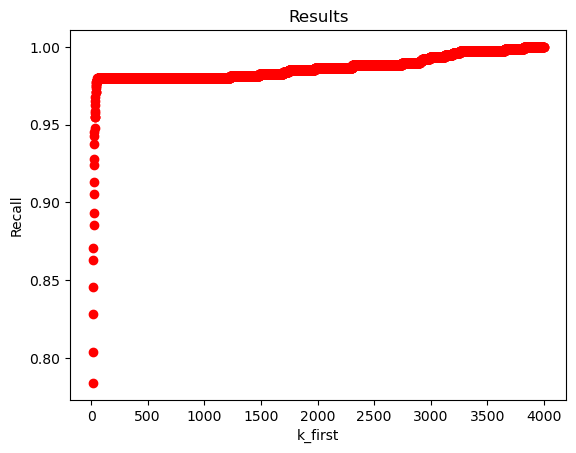

In [72]:
import matplotlib.pyplot as plt



def plot_results(results):
    average_results = calculate_average_results(results)
    x = [k_first for k_first, average in average_results]
    y = [average for k_first, average in average_results]    
    plt.plot(x, y, 'ro')
    plt.xlabel('k_first')
    plt.ylabel('Recall')
    plt.title('Results')
    graph =plt.show()
    return graph


graph = plot_results(results)
graph
